# Sea Ice Extent Timeseries
## **SOSE**

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.454b7ccb9e9a4bac886d33432dfb95a6 Dashboard: /services/dask-gateway/clusters/staging.454b7ccb9e9a4bac886d33432dfb95a6/status,Cluster Workers: 30 Cores: 60 Memory: 240.00 GiB


In [63]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [5]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["SOSE"].to_dask()

In [6]:
coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables

<ipython-input-6-048d900fe850>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700) #ds split into coords
<ipython-input-6-048d900fe850>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700) #ds dropping coords so it just holds data variables


In [7]:
dsr = dsr_before_drop.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords_before_drop.drop(['XC', 'YC', 'XG', 'YG'])

In [8]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [9]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

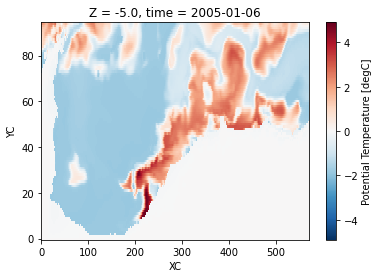

In [10]:
dsr.THETA[0,0].isel(**lat_range, **lon_range).plot()#.drop(['XC', 'YC']).plot()

In [18]:
dsr.SFLUX == 0

<xarray.DataArray 'SFLUX' (time: 438, YC: 320, XC: 2160)>
dask.array<eq, shape=(438, 320, 2160), dtype=bool, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Dimensions without coordinates: YC, XC

In [33]:
coords.hFacC[0]

<xarray.DataArray 'hFacW' (YC: 320, XG: 2160)>
dask.array<getitem, shape=(320, 2160), dtype=float32, chunksize=(320, 2160), chunktype=numpy.ndarray>
Coordinates:
    Z        float32 -5.0
Dimensions without coordinates: YC, XG
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction_at_u_location

In [36]:
mask = (coords.hFacC[0]>0).isel(**lat_range, **lon_range)

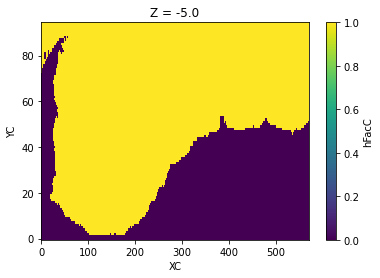

In [38]:
mask.plot()

In [12]:
dsr.SIarea

<xarray.DataArray 'SIarea' (time: 438, YC: 320, XC: 2160)>
dask.array<rechunk-merge, shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

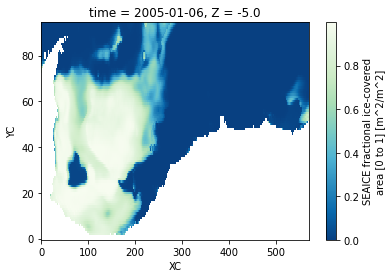

In [55]:
dsr.SIarea[0].isel(**lat_range, **lon_range).where(mask).plot(cmap='GnBu_r')

In [59]:
dsr.SIarea.isel(**lat_range, **lon_range).where(mask)

<xarray.DataArray 'SIarea' (time: 438, YC: 95, XC: 570)>
dask.array<where, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Z        float32 -5.0
Dimensions without coordinates: YC, XC
Attributes:
    long_name:      SEAICE fractional ice-covered area [0 to 1]
    standard_name:  SIarea
    units:          m^2/m^2

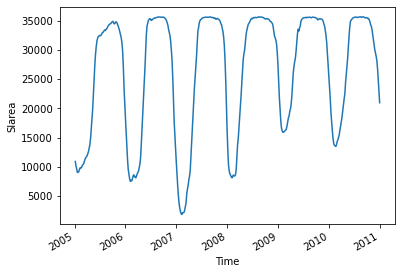

In [61]:
dsr.SIarea.isel(**lat_range, **lon_range).sum(['XC', 'YC']).plot();